In [1]:
!wget -O mni_icbm152_nlin_asym_09c_nifti.zip  https://www.dropbox.com/s/vd2xjqrqy7u00vl/mni_icbm152_nlin_asym_09c_nifti.zip?dl=0
!unzip -o  mni_icbm152_nlin_asym_09c_nifti.zip

!wget -O ds001420-download.zip https://www.dropbox.com/sh/h8z155ezh7py8b1/AAC4tMz_SGQbcoJ9wr0cuaM6a?dl=1 ds001420-download
!unzip -o -d ds001420-download  ds001420-download.zip

import os
import nibabel as nib
import numpy as np


def get_section(filename):
    if os.path.exists(filename):
        vol = nib.load(filename).get_fdata()
        z = int(vol.shape[2]/2)
        section = vol[:,:,z]
        return section
    else :
        print('Error: file does not exist', filename)
        return 1
    


--2021-06-01 08:49:03--  https://www.dropbox.com/s/vd2xjqrqy7u00vl/mni_icbm152_nlin_asym_09c_nifti.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/vd2xjqrqy7u00vl/mni_icbm152_nlin_asym_09c_nifti.zip [following]
--2021-06-01 08:49:04--  https://www.dropbox.com/s/raw/vd2xjqrqy7u00vl/mni_icbm152_nlin_asym_09c_nifti.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1601332c69372264f261749555.dl.dropboxusercontent.com/cd/0/inline/BPnvn_XT6EVBGJ4TCgXOdMauZ6EAx3GZrsRoB8Ygu20j9HbtJnsO08Tmmc0_oQJzy4LtRcWeu3MdKeKIIhczZ5wrvBScCQhV1oSi-JlMdBHsaCi7IC1hG_4e3XefJP_fhNGe05HCFO1wScbNCOeHjTv5/file# [following]
--2021-06-01 08:49:05--  https://uc1601332c69372264f261749555.dl.dropboxusercontent.com/cd/0/inline/BPnvn_XT6EVBG

In [3]:
### 1. Resampling


# Downsampling means reducing the resolution of an image.
# This basically involves interpolating the original, higher resolution image, onto a lower resolution grid
#
# Upsampling is the opposite. You interpolate a lower resolution grid onto a higher resolution one.
#
# Example of downsampling :
#
#  1mm grid            3mm grid   
#  _ _ _ _ _ _        _____ _____  
# |_|_|_|_|_|_|      |     |     |  
# |_|_|_|_|_|_|      |     |     |
# |_|_|_|_|_|_|  --> |_____|_____|
# |_|_|_|_|_|_|      |     |     |
# |_|_|_|_|_|_|      |     |     |
# |_|_|_|_|_|_|      |_____|____ |
#

import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np


brain_filename='hacking_hour/data/full16_1000um_optbal.nii.gz'

section = get_section(brain_filename)
section = section.max() - section

dims = np.array([section.shape[0]/4, section.shape[1]/4]).astype(int)

# by default, resize() will take methods to prevent aliasing
section_rsl = resize(section, dims, order=0, anti_aliasing=False)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(section)
plt.subplot(1,2,2)
plt.imshow(section_rsl)

plt.show()

<Figure size 1200x1200 with 2 Axes>

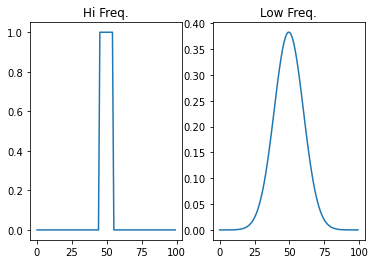

In [4]:
### Filtering

# Frequency spectrum
# Signals (such as images, time-series, audio recordings, etc.) are made of up different frequencies
# Sharp changes in an image are created by high frequencies
# Low frequencies produce more gradual changes in an image
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(100) 
hi_freq = np.zeros([100])
hi_freq[45:55] = 1


low_freq = gaussian_filter(hi_freq,10)

# We can display multiple plots or images with "subplot" function in pyplot
plt.subplot(1,2,1)
plt.title('Hi Freq.') #create a title for the subplot
plt.plot(x,hi_freq) # create a line plot
plt.subplot(1,2,2)
plt.title('Low Freq.')
plt.plot(x,low_freq)
plt.show()

/home/t/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))


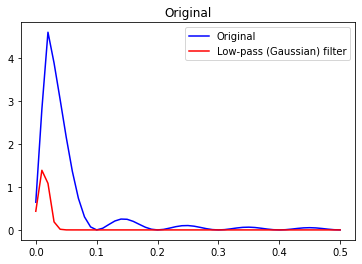

In [5]:
# You can visualize the frequencies that make up an image (i.e., its "frequency spectrum")
# using the "welch" function.
# It shows the different frequencies present in the image on the x-axis and the "power" or strength
# of these frequencies on the y-axis
from scipy.signal import welch
f0, hi_freq_spectrum = welch(hi_freq)
f1, low_freq_spectrum = welch(low_freq)

#As you can see, Gaussian filtering attenuates the higher frequencies present in the high frequency image
plt.title('Original')
plt.plot(f0, hi_freq_spectrum, c='b', label='Original')
plt.plot(f1, low_freq_spectrum,c='r', label='Low-pass (Gaussian) filter')
plt.legend()
plt.show()

In [6]:
### Exercise
# Try changing the size of the standard deviation in the gaussian filter above.
# Then rerun the welch cell above



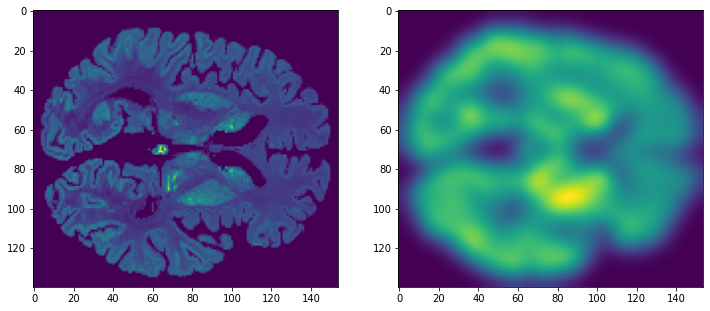

In [7]:
### Filtering images
section_gauss = gaussian_filter(section,5) # blurs image with gaussian filter

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(section)
plt.subplot(2,2,2)
plt.imshow(section_gauss)
plt.show()

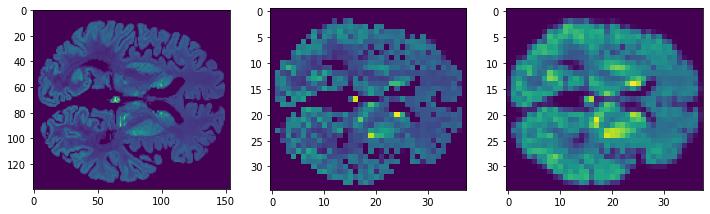

In [8]:
# Prefiltering

# Without prefiltering
#       1mm                            5mm
#                              |------------------| 
# 100| 1 | 0 | 0 | 0           |                  |
# --------------------         |                  |
# 1  | 0 | 0 | 0 | 0           |                  |
# --------------------         |                  |
# 0  | 0 | 0 | 0 | 0     --->  |       0          | => misses high intensity pixel within area of new, low res. pixel
# --------------------         |                  |
# 0  | 0 | 0 | 0 | 0           |                  |
# --------------------         |                  |
# 0  | 0 | 0 | 0 | 0           |------------------|


# With prefiltering :
#         1mm                          5mm
#                              |------------------| 
# 80 | 50 | 25 | 10 | 5        |                  |
# --------------------         |                  |
# 50 | 45 | 20 | 10 | 5        |                  |
# --------------------         |                  |
# 25 | 20 | 15 | 10 | 4  --->  |       18.5       | => includes intensities of all pixels within area of new, low res. pixel
# --------------------         |                  |
# 10 | 10 | 10 | 10 | 3        |                  |
# --------------------         |                  |
# 5  | 5  | 4  | 3  | 2        |------------------|



# Before downsampling it is essential to filter the image to prevent 'aliasing'
# Aliasing is an artefact that occurs when trying to represent high-resolution
# information at too low a resolution. Blurring the high-resolution image effectively
# reduces the resolution of the image to the target lower resolution before 
# interpolating on the lower resolution grid.


section_blur = gaussian_filter(section,1.5)
section_blur_rsl = resize( section_blur, dims, order=0, anti_aliasing=False)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(section)
plt.subplot(1,3,2)
plt.imshow(section_rsl)
plt.subplot(1,3,3)
plt.imshow(section_blur_rsl)
plt.savefig('downsample.png')

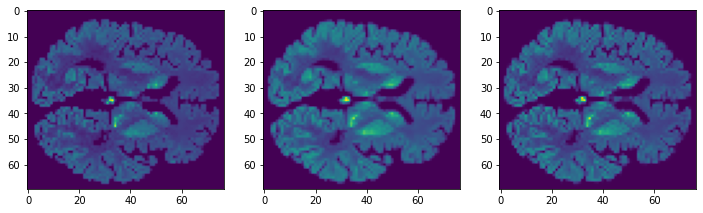

In [9]:
# Interpolation method

# As mentioned above, resampling involves interpolating an image onto a grid at a lower resolution
# You can use different interpolation algorithms to do this. 
# common polynomial interpolation techniques
# -> nearest neighbour (order 0) 
# -> linear (order 1)
# -> cubic (order 2)
#    etc.

# higher order --> smoother interpolated image in part because the interpolated value is based 
#                  on a wider neighbourhood of surrounding pixels
# nearest neighbour interpolation is very important for images with discrete values 
dims = np.array([section.shape[0]/2, section.shape[1]/2]).astype(int)
section_0 = resize(section, dims, order=0, anti_aliasing=False)
section_1 = resize(section, dims, order=1, anti_aliasing=False)
section_5 = resize(section, dims, order=5, anti_aliasing=False)


plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(section_0)
plt.subplot(1,3,2)
plt.imshow(section_1)
plt.subplot(1,3,3)
plt.imshow(section_5)
plt.savefig('interpolation.png')

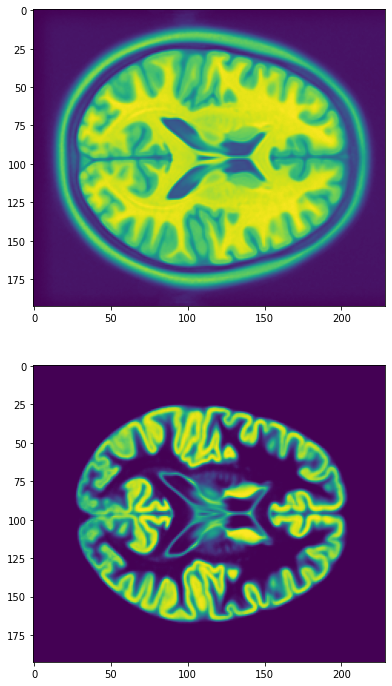

In [10]:
import nibabel as nib
import matplotlib.pyplot as plt

atlas_template="mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c.nii"
seg_fn = "mni_icbm152_nlin_asym_09c/mni_icbm152_gm_tal_nlin_asym_09c.nii"

plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.imshow(get_section(atlas_template))
plt.subplot(2,1,2)
plt.imshow(get_section(seg_fn))
plt.show()

MNI Atlas
	Affine (x,y,z)
[[   1.    0.    0.  -96.]
 [   0.    1.    0. -132.]
 [   0.    0.    1.  -78.]
 [   0.    0.    0.    1.]]
	Dimensions
(193, 229, 193)
Subject MRI
	Affine (x,y,z)
[[  -1.21875     0.          0.        156.      ]
 [   0.          1.21875     0.       -156.      ]
 [   0.          0.          1.21875  -126.140625]
 [   0.          0.          0.          1.      ]]
	Dimensions
(256, 256, 207)


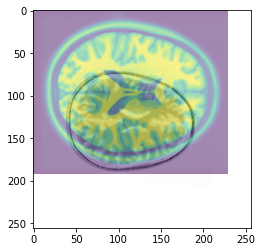

In [11]:

sub='01'
ses='baseline'
mri_fn=f'ds001420-download/sub-{sub}/ses-{ses}/anat/sub-{sub}_ses-{ses}_space-pet_T1w_uint16.nii.gz'

atlas_img = nib.load(atlas_template)
t1_img = nib.load(mri_fn)

print('MNI Atlas')
print('\tAffine (x,y,z)')
print(atlas_img.affine)

print('\tDimensions')
print(atlas_img.shape)


print('Subject MRI')
print('\tAffine (x,y,z)')
print(t1_img.affine)

print('\tDimensions')
print(t1_img.shape)

t1_slice = get_section(mri_fn)
atlas_slice = get_section(atlas_template)


plt.imshow(atlas_slice)
plt.imshow(t1_slice, cmap='Greys', alpha=0.5)
plt.show()



Subject MRI Resampled
	Affine (x,y,z)
[[   1.    0.    0.  -96.]
 [   0.    1.    0. -132.]
 [   0.    0.    1.  -78.]
 [   0.    0.    0.    1.]]
	Dimensions (x,y,z)
(193, 229, 193)


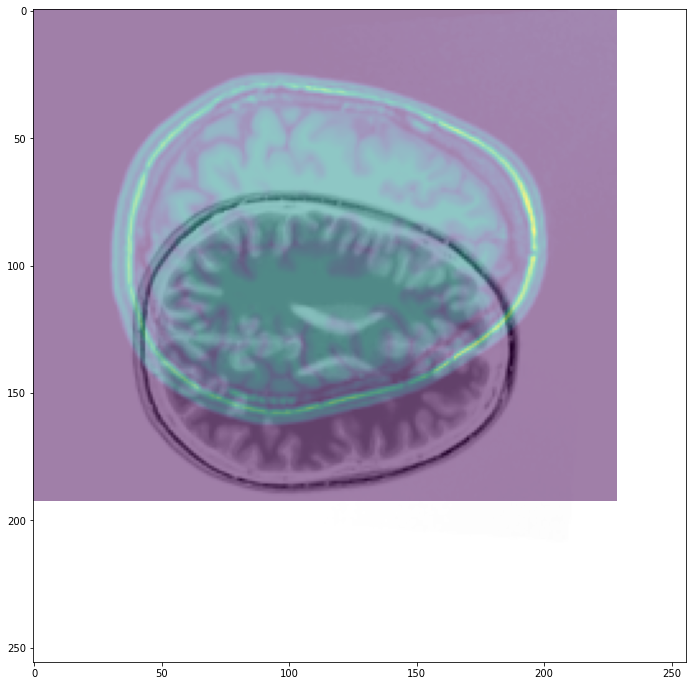

In [14]:
from nibabel.processing import resample_from_to

t1_img_rsl = resample_from_to(t1_img, atlas_img)
t1_img_rsl.to_filename('t1_rsl.nii.gz')

print('Subject MRI Resampled')
print('\tAffine (x,y,z)')
print(t1_img_rsl.affine)
print('\tDimensions (x,y,z)')
print(t1_img_rsl.shape)

t1_slice_rsl = get_section('t1_rsl.nii.gz')

plt.figure(figsize=(12,12))
plt.imshow(t1_slice_rsl)
plt.imshow(t1_slice, cmap='Greys', alpha=0.5)
plt.show()

In [19]:
import ants

atlas_template="mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c.nii"

mri_fn=f'ds001420-download/sub-01/ses-baseline/anat/sub-01_ses-baseline_space-pet_T1w_uint16.nii.gz'

fixed=ants.image_read(mri_fn)
moving=ants.image_read(atlas_template)



dict_keys(['warpedmovout', 'warpedfixout', 'fwdtransforms', 'invtransforms'])


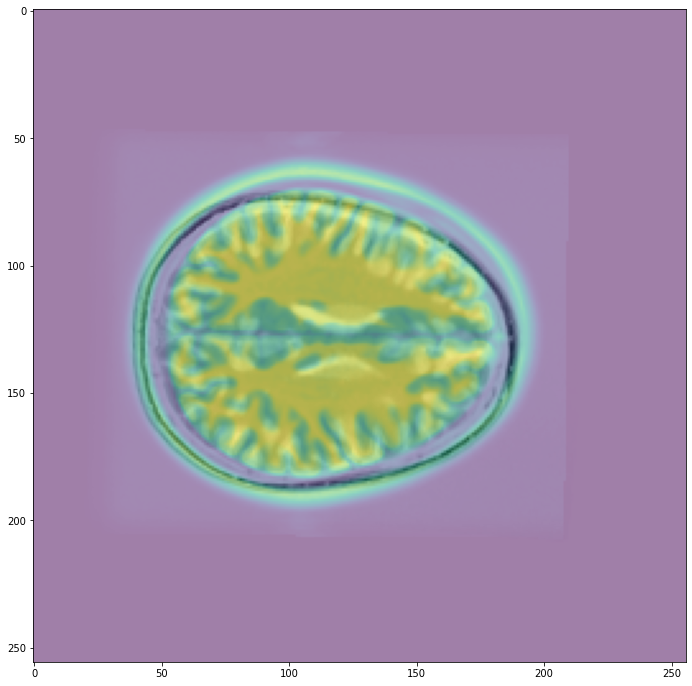

In [20]:
# Affine transformations are applied uniformly across each dimension
# Affine transformations can be represented by a single 4x4 matrix

# Rigid Transformation = 6 parameters
# 3 translations 
# 3 rotations

rigid_tfm = ants.registration(fixed=fixed, moving=moving, type_of_transform='Rigid', outprefix='rigid')

print(rigid_tfm.keys())

z = int(rigid_tfm['warpedmovout'].shape[2]/2)
rigid_section = rigid_tfm['warpedmovout'][:,:,z]

plt.figure(figsize=(12,12))
plt.imshow(rigid_section)
plt.imshow(t1_slice, cmap='Greys', alpha=0.5)
plt.show()

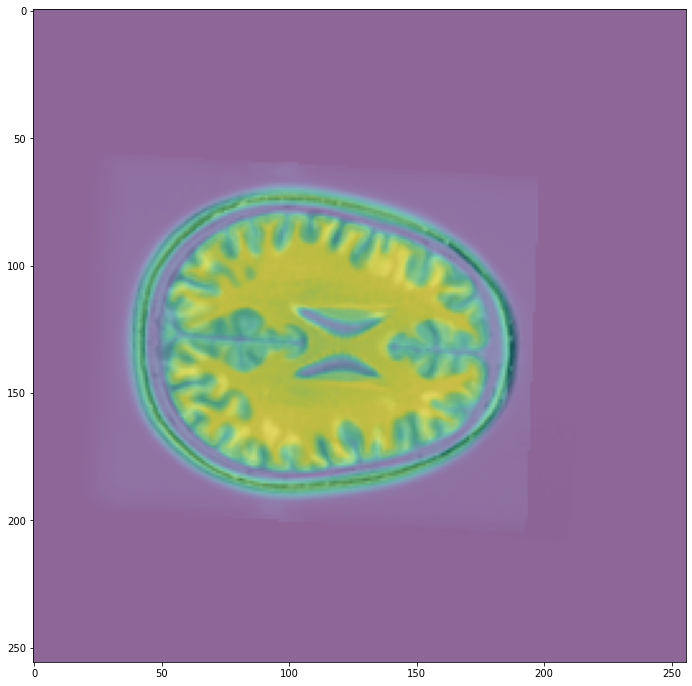

In [17]:
# Affine Transformation = 12 parameters
# 3 x translations 
# 3 x rotations
# 3 x scaling
# 3 x shearing

affine_tfm = ants.registration(fixed=fixed, moving=moving, type_of_transform='Affine', outprefix='affine')

z = int(affine_tfm['warpedmovout'].shape[2]/2)
affine_section = affine_tfm['warpedmovout'][:,:,z]

plt.figure(figsize=(12,12))
plt.imshow(affine_section)
plt.imshow(t1_slice, cmap='Greys', alpha=0.40)
plt.show()

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 207)
	 Spacing    : (1.2188, 1.2188, 1.2188)
	 Origin     : (-156.0, 156.0, -126.1406)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]



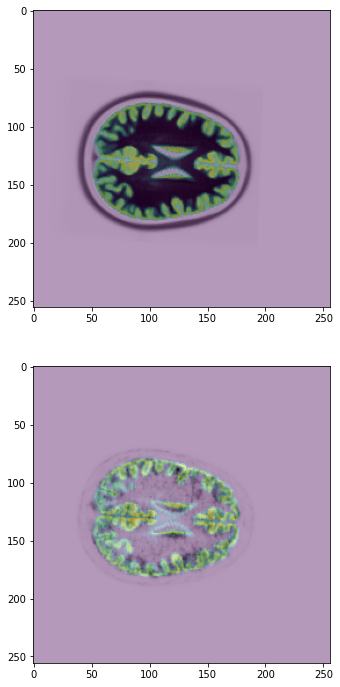

In [18]:
#Apply transforms to another volume
pet_fn='ds001420-download/sub-01/ses-baseline/pet/sub-01_ses-baseline_pet.nii.gz'

pet_section = get_section(pet_fn)

fixed=ants.image_read(mri_fn)
moving_seg=ants.image_read(seg_fn)

fwdtransform = ants.read_transform(affine_tfm['fwdtransforms'][0])

seg_tfm = ants.apply_transforms(fixed, moving_seg, transformlist=affine_tfm['fwdtransforms'][0], interpolator='nearestNeighbor')

print(seg_tfm)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.imshow(affine_section, cmap='Greys')
plt.imshow(seg_tfm[:,:,z],  alpha=0.40)
plt.subplot(2,1,2)
plt.imshow(pet_section, cmap='Greys')
plt.imshow(seg_tfm[:,:,z],  alpha=0.40)
plt.show()